# Plots used for the PowerPoint presentation

In [1]:
# Import all the necessary libraries
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import folium

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (10,10)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv
from windrose import WindroseAxes
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fftpack import fft2,fftshift,ifft2,ifftshift
from scipy.special import kv
import matplotlib 
from matplotlib import pyplot as plt


warnings.filterwarnings('ignore')

In [2]:
# Parameters
topo_file = 'data/NorthBerwickLawBlend1.txt'       # Topography file name
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

In [3]:
z = np.loadtxt(topo_file)
n = z.shape[0]

## Define a function which calculates the u and v component and wind

def wind_model(n,zr):
    """
    Function to calculate the wind components and overal wind
    Input: 
    - n: n = zr.shape[0]
    - zr: Topography file to be read in
    Output: Wind components and overal wind
    """
    # Iteration to find the inner region thickness l (m)
    l = (z0/8)*(L/z0)**0.9
    for i in range(10):
        l = 2*0.16*L/np.log(l/z0)
    a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))
    
    # Fourier transform
    Fz = fft2(zr)
    Fz = fftshift(Fz)
    
    # Wavenumbers and modified Bessel functions
    k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
    m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
    bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
    bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
    bu[int(n/2)] = 0
    bv[int(n/2)] = 0
    
    # Fourier components of u and v
    Fu = np.zeros_like(Fz)
    Fv = np.zeros_like(Fz)
    for i in range(n):
        for j in range(n):
            r = np.sqrt(k[j]**2 + m[i]**2)
            if r>0:
                Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
                Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]
    
    # Inverse Fourier transform
    Fu = ifftshift(Fu)
    Fv = ifftshift(Fv)
    ur = 1 + np.real(ifft2(Fu))
    vr = np.real(ifft2(Fv))
    windr = np.sqrt(ur**2 + vr**2)
    return ur,vr,windr

In [46]:
# Define a function to plot the streamplot and the contour lines

def plot_wind(u,v,wind,z,title, n, m, l, col_bar_min, col_bar_max, col_extend):
    """
    Input:
    - u, v: wind components
    - wind: overall wind
    - z: topography 
    - title: title of the plot
    Output  Plots streamsplot and topography
    """
    x = np.arange(-n,n)*dx
    y = np.arange(-n,n)*dx
    print(wind.min(), wind.max())
    plt.streamplot(x[m:l],y[m:l],u[m:l,m:l],v[m:l,m:l],
                   color=wind[m:l,m:l],
                   linewidth = 5, cmap='coolwarm',
                  norm = matplotlib.colors.DivergingNorm(vmin = col_bar_min, vcenter = 1, vmax = col_bar_max))
    cbar = plt.colorbar(extend = col_extend, orientation = "horizontal")
    cbar.set_label('Wind speed [ms$^{-1}$]', fontsize = 25)
                   
    plt.clim(col_bar_min, col_bar_max)
    cbar.ax.tick_params(labelsize=20)
    cs = plt.contour(x[m:l],y[m:l],z[m:l,m:l],origin='lower', alpha = 0.7, colors='k')
    plt.clabel(cs, fmt='%d')
    plt.xlabel('Distance to East [m]', fontsize = 25)
    plt.ylabel('Distance to North [m]', fontsize = 25)
    plt.title(title)

In [47]:
# Define function using the Ninja model output

def Ninja_plots(z, u, v, title, col_bar_min, col_bar_max, n, m, l, col_extend):
    """
    Input:
    - z: elevation file
    - vel: velocity profile from Ninja model
    - ang: angle from Ninja model
    - title: title for subplot
    - col_bar_min and _max: min and max of colorbar (to ensure that colorbar are the same for subplots)
    
    Output: plots a streamplot with the streamlines colored in by wind speed
    """
    u = -vel*np.sin(np.radians(ang))
    v = vel*np.cos(np.radians(ang))
    u = u[::-1,:]
    v = -v[::-1,:]
    wind = np.sqrt(u**2 + v**2)
    
    x = np.arange(-n,n)*dx
    y = np.arange(-n,n)*dx
    plt.streamplot(x[m:l],y[m:l],u[m:l,m:l],v[m:l,m:l],
                   color=wind[m:l,m:l],cmap='coolwarm', linewidth = 5, 
                  norm = matplotlib.colors.DivergingNorm(vmin = col_bar_min, vcenter = 1, vmax = col_bar_max))
# cmocean.cm.curl    
# RdYlBu_r
    cbar = plt.colorbar(extend = col_extend, orientation = "horizontal")
    cbar.set_label('Wind speed [ms$^{-1}$]', fontsize = 25)
    plt.clim(col_bar_min, col_bar_max)
    cbar.ax.tick_params(labelsize=20)
    cs = plt.contour(x[m:l],y[m:l],z[m:l,m:l],alpha = 0.7, colors='k')
    plt.clabel(cs,fmt='%d')
    plt.xlabel('Distance to East [m]', fontsize = 25)
    plt.yticks(visible = False)
    #plt.ylabel('Distance to North [m]', fontsize = 20)
    plt.title(title)

0.34109544828657035 2.493387764469251


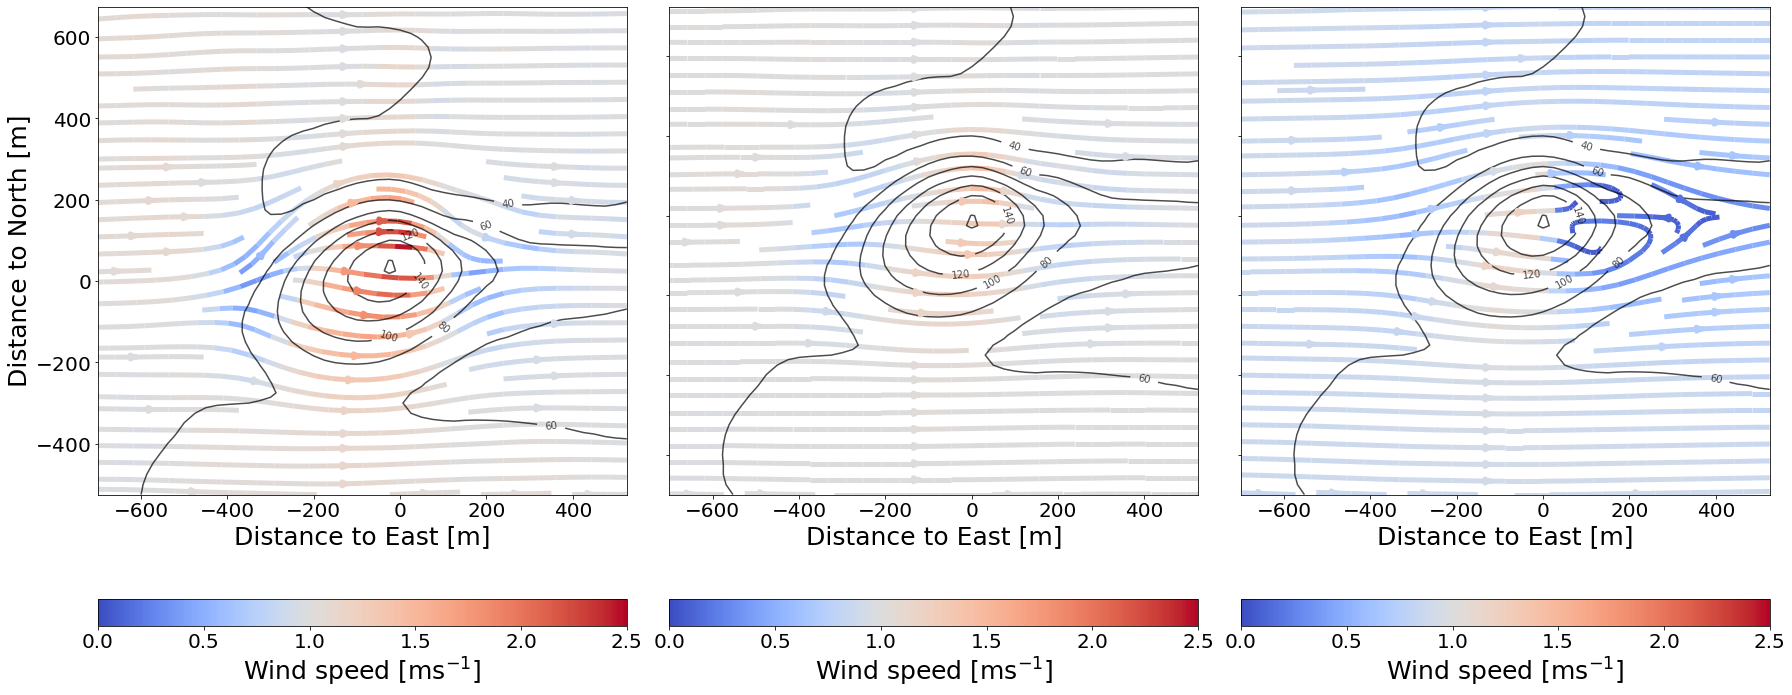

In [48]:
# westerly wind at 2m with different models compared
plt.figure(figsize = (25, 10))

# Westerly wind with the linear model
plt.subplot(131)
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)
z = np.loadtxt('data/NorthBerwickLawBlend1.txt')
n = z.shape[0]
u, v, wind = wind_model(n,z)
plot_wind(u,v,wind,z,'', 128, 100, 150, col_bar_min = 0, col_bar_max = 2.5, col_extend = "neither")
plt.ylim(525,-675)
plt.yticks([400, 200, 0, -200, -400, -600],['$-$400', '$-$200', '0', '200', '400', '600'], fontsize = 20)
plt.xticks(fontsize = 20)


# Westerly wind with the WindNinja Conservation of Mass model
from osgeo import gdal
ds = gdal.Open('data/NorthBerwickLaw.tif')
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
z = z[::-1,:]
plt.subplot(132)
vel = np.loadtxt('data/NorthBerwickLaw_270_1_25m_vel.asc',skiprows=6)
ang = np.loadtxt('data/NorthBerwickLaw_270_1_25m_ang.asc',skiprows=6)
Ninja_plots(z, vel, ang, "", 
            col_bar_min = 0, col_bar_max=2.5, n=128, m=100, l=150, col_extend = "neither")
plt.xticks(fontsize = 20)

# Westerly wind with the WindNinja Conservation of Mass and Momentum model
plt.subplot(133)
ds = gdal.Open('data/NorthBerwickLaw.tif')
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
z = z[::-1,:]
vel = np.loadtxt('data/NorthBerwickLaw_270_1_25m_vel_mm.asc',skiprows=6)
ang = np.loadtxt('data/NorthBerwickLaw_270_1_25m_ang_mm.asc',skiprows=6)
Ninja_plots(z, vel, ang, "", 
            col_bar_min = 0, col_bar_max=2.5, n=128, m=100, l=150, col_extend = "neither")
plt.xticks(fontsize = 20)

#fig.set_figheight(8)
#fig.set_figwidth(20)
plt.tight_layout()
plt.savefig("Pow_B.pdf",bbox_inches="tight")
plt.show()

0.02275671809970284 6.488398750768855


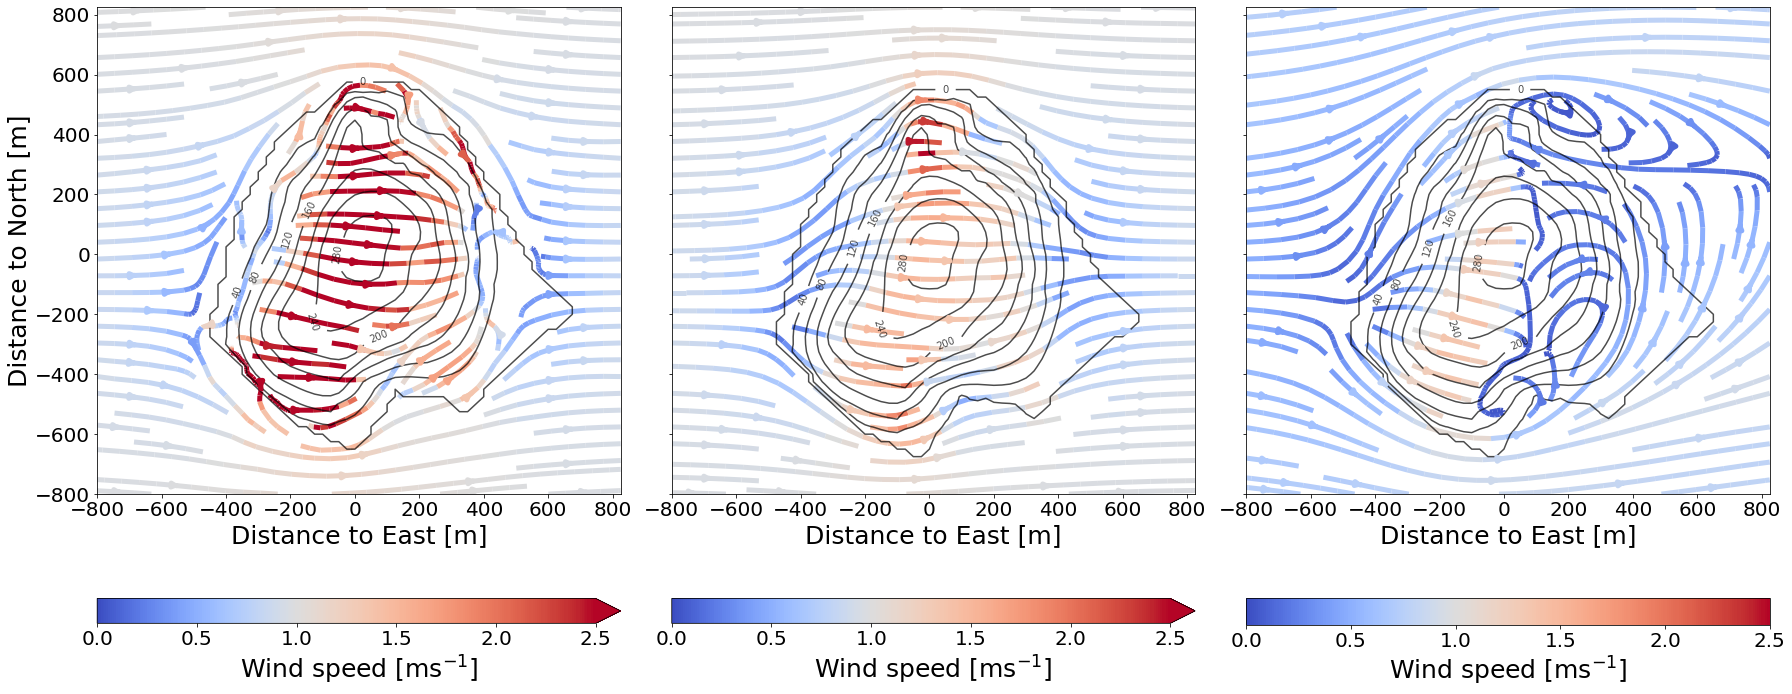

In [49]:
# westerly wind at 2m with different models compared
plt.figure(figsize=(25, 10))

# Westerly wind with the linear model
plt.subplot(131)
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)
z = np.loadtxt('data/AilsaCraig.txt')
n = z.shape[0]
u, v, wind = wind_model(n,z)
plot_wind(u,v,wind,z,'', 127, 95, 161, col_bar_min = 0, col_bar_max=2.5, col_extend = "max")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

# Westerly wind with the WindNinja Conservation of Mass model
from osgeo import gdal
ds = gdal.Open('data/AilsaCraig.tif')
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
z = z[::-1,:]
plt.subplot(132)
vel = np.loadtxt('data/AilsaCraig_270_25m_2m_vel.asc',skiprows=6)
ang = np.loadtxt('data/AilsaCraig_270_25m_2m_ang.asc',skiprows=6)
Ninja_plots(z, vel, ang, "", 
            col_bar_min = 0, col_bar_max=2.5, n=127, m=95, l=161, col_extend = "max")
plt.xticks(fontsize = 20)

# Westerly wind with the WindNinja Conservation of Mass and Momentum model
plt.subplot(133)
ds = gdal.Open('data/AilsaCraig.tif')
band = ds.GetRasterBand(1)
z = band.ReadAsArray()
z = z[::-1,:]
vel = np.loadtxt('data/AilsaCraig_270_1_25m_vel_mm.asc',skiprows=6)
ang = np.loadtxt('data/AilsaCraig_270_1_25m_ang_mm.asc',skiprows=6)
Ninja_plots(z, vel, ang, "", 
            col_bar_min = 0, col_bar_max=2.5, n=127, m=95, l=161, col_extend = "neither")
plt.xticks(fontsize = 20)

#fig.set_figheight(17)
#fig.set_figwidth(8)
plt.tight_layout()
plt.savefig("Pow_A.pdf",bbox_inches="tight")
plt.show()

In [50]:
# Reading in the data
elevation_I = np.loadtxt('data/Inchkeith.txt')

In [51]:
## Calculate wind
# Parameters
topo_file_I = 'data/Inchkeith.txt'       # Topography file name
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

# Simulation with 1 m s$^{-1}$ wind from the west:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))
print(l)
z = np.loadtxt(topo_file_I)
n = z.shape[0]
Fz = fft2(z)
Fz = fftshift(Fz)

# Wavenumbers and modified Bessel functions
k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
bu[int(n/2)] = 0
bv[int(n/2)] = 0

# Fourier components of u and v
Fu = np.zeros_like(Fz)
Fv = np.zeros_like(Fz)
for i in range(n):
    for j in range(n):
        r = np.sqrt(k[j]**2 + m[i]**2)
        if r != 0:
            Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
            Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

# Inverse Fourier transform
Fu = ifftshift(Fu)
Fv = ifftshift(Fv)
u = 1 + np.real(ifft2(Fu))
v = np.real(ifft2(Fv))
wind = np.sqrt(u**2 + v**2)

# Vertical wind component from continuity equation
w = np.zeros_like(wind)
dzdx = (z[1:-1,2:] - z[1:-1,:-2])/(2*dx)
dzdy = (z[2:,1:-1] - z[:-2,1:-1])/(2*dx)
w[1:-1,1:-1] = u[1:-1,1:-1]*dzdx + v[1:-1,1:-1]*dzdy

20.92558381778936


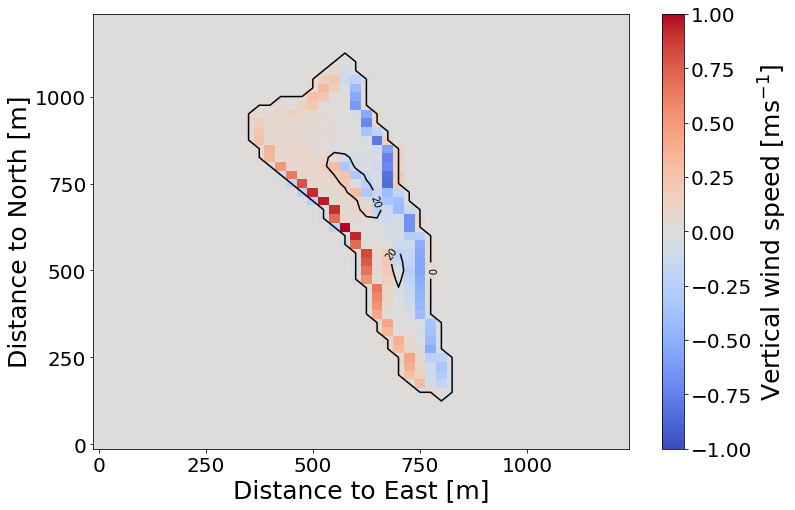

In [52]:
# Plot vertical wind component and topography for 1 km x 1 km area centred on the summit
fig, ax = plt.subplots(figsize=(12,8))

plt.imshow(w[95:145, 105:155],origin='lower', aspect='auto', cmap = "coolwarm")  # north at the top of the image
#plt.imshow(w[95:145, 95:145],origin='lower', aspect='auto', cmap = "seismic")
plt.clim(-1, 1)
cbar = plt.colorbar()
cbar.set_label('Vertical wind speed [ms$^{-1}$]', fontsize = 25)
cbar.ax.tick_params(labelsize=20)
cs = plt.contour(z[95:145, 105:155],colors='k',levels=np.arange(0,1000,20))
plt.clabel(cs,fmt='%d')
plt.xlabel("Distance to East [m]", fontsize = 25)
plt.ylabel("Distance to North [m]", fontsize = 25)
plt.xticks(np.arange(0, 50, step=10), labels=[0, 250, 500, 750, 1000], fontsize = 20)
plt.yticks(np.arange(0, 50, step=10), labels=[0, 250, 500, 750, 1000], fontsize = 20)
#plt.title("Vertical wind component over Inchkeith")
plt.savefig("Pow_I.pdf",bbox_inches="tight")

20.92558381778936
2.7500407304041357 0.007283841480819223


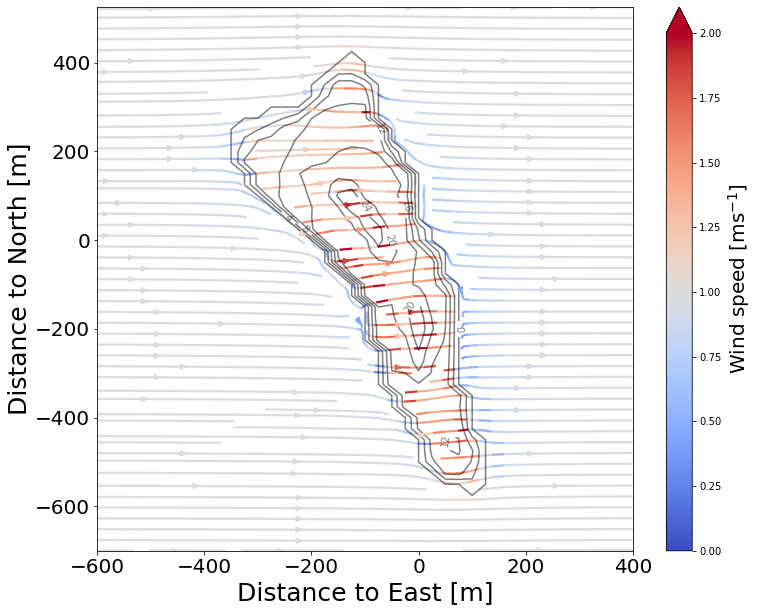

In [45]:
## Calculate wind
# Parameters
topo_file_I = 'data/Inchkeith.txt'       # Topography file name
dx = 25                     # Grid spacing (m)
L  = 500.                   # Horizontal length scale (m)
z0 = 0.01                    # Surface roughness length (m)
zu = 2.                      # Wind measurement height (m)

# Simulation with 1 m s$^{-1}$ wind from the west:
"""
Linear model for turbulent flow over low hills derived
from Jackson and Hunt (1975), Mason and Sykes (1979)
"""

# Iteration to find the inner region thickness l (m)
l = (z0/8)*(L/z0)**0.9
for i in range(10):
    l = 2*0.16*L/np.log(l/z0)
a = (np.log(L/z0))**2/(np.log(l/z0)*np.log(zu/z0))
print(l)

# Read the topography file, find size and take a Fourier transform
z = np.loadtxt(topo_file_I)
n = z.shape[0]
Fz = fft2(z)
Fz = fftshift(Fz)

# Wavenumbers and modified Bessel functions
k = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)       
m = (2*np.pi/(n*dx))*np.arange(-n/2,n/2)
bu = 1 - kv(0,2*np.sqrt(1j*L*k*zu/l))/kv(0,2*np.sqrt(1j*L*k*z0/l))
bv = 1 - kv(0,2*np.sqrt(2*1j*L*k*zu/l))/kv(0,2*np.sqrt(2*1j*L*k*z0/l))
bu[int(n/2)] = 0
bv[int(n/2)] = 0

# Fourier components of u and v
Fu = np.zeros_like(Fz)
Fv = np.zeros_like(Fz)
for i in range(n):
    for j in range(n):
        r = np.sqrt(k[j]**2 + m[i]**2)
        if r != 0:
            Fu[i,j] = a*bu[j]*(k[j]**2/r)*Fz[i,j]
            Fv[i,j] = a*bv[j]*(k[j]*m[i]/r)*Fz[i,j]

# Inverse Fourier transform
Fu = ifftshift(Fu)
Fv = ifftshift(Fv)
u = 1 + np.real(ifft2(Fu))
v = np.real(ifft2(Fv))
wind = np.sqrt(u**2 + v**2)
print(wind.max(), wind.min())

# Vertical wind component from continuity equation
w = np.zeros_like(wind)
dzdx = (z[1:-1,2:] - z[1:-1,:-2])/(2*dx)
dzdy = (z[2:,1:-1] - z[:-2,1:-1])/(2*dx)
w[1:-1,1:-1] = u[1:-1,1:-1]*dzdx + v[1:-1,1:-1]*dzdy
#X = np.arange(0, 256)
#Y = np.arange(0, 256)
X = np.arange(-128,128)*dx
Y = np.arange(-128,128)*dx
fig, ax = plt.subplots(figsize=(12, 10))
strm = plt.streamplot(X[95:145], Y[100:150], u[95:145, 100:150], v[95:145, 100:150], color=wind[95:145, 100:150],  
                cmap='coolwarm',linewidth = 2.2,density = 1.7,
                  norm = matplotlib.colors.DivergingNorm(vmin = 0, vcenter = 1, vmax = 2))

#strm = plt.streamplot(X, Y, u, v, color=wind, cmap='coolwarm',linewidth = 2.2,density = 1.7, norm = matplotlib.colors.DivergingNorm(vmin = 0, vcenter = 1, vmax = 2))
cbar = plt.colorbar(extend = "max")
cbar.set_label('Wind speed [ms$^{-1}$]', fontsize = 20)
plt.clim(0, 2)


cs = plt.contour(X[95:145],Y[100:150],z[95:145, 100:150],alpha = 0.5, colors='k')
plt.clabel(cs,fmt='%d')
plt.xlabel('Distance to East [m]', fontsize = 25)
plt.ylabel('Distance to North [m]', fontsize = 25)
#plt.ylim(-500, 500)
plt.xlim(-600, 400)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


#plt.xticks([100, 110, 120, 130, 140], labels=[-])
#plt.yticks([100, 110, 120, 130, 140], labels=[300, 200, 100, 0, -100, -200, -300, -400])

#set colourbar according to wind speed
#cbar = fig.colorbar(strm.lines)
#cbar.ax.set_ylabel('Wind speed [ms$^{-1}$]', fontsize = 20)

plt.savefig("Pow_I2.pdf",bbox_inches="tight")